# OCR Preprocessing Pipeline for Renaissance Documents

This notebook randomly samples pages from a set of PDF documents, converts them to images, and applies a standard OCR preprocessing pipeline:
- Grayscale conversion
- Noise removal (median filter)
- Binarization (Otsu’s threshold)
- Deskewing

You'll end up with clean, black-and-white PNG files ready for OCR.



### 1. Install Dependencies

Run the following cell to install necessary packages (requires Poppler installed on your system):


In [2]:

%pip install pdf2image opencv-python numpy gdown



Note: you may need to restart the kernel to use updated packages.



### 2. Imports and Configuration

Adjust the paths below to point to your PDF directory and desired output folder.

In [7]:
import os
import random
from pdf2image import convert_from_path, pdfinfo_from_path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Disable PIL bomb check
Image.MAX_IMAGE_PIXELS = None

# Configuration
pdf_dir = '/data/pdfs'
pdf_samples_dir = '/data/pdf_samples'
png_dir = '/data/pngs'
processed_dir = '/data/processed_data'
processed_resized_dir = '/data/processed_resized'
POPPLER_PATH = 'C:/Users/katej/OneDrive/Documents/Downloads/Release-24.08.0-0/poppler-24.08.0/Library/bin/'

os.makedirs(processed_dir, exist_ok=True)

# Set DPI for conversion
DPI = 300

# Number of documents and pages to sample
NUM_DOCUMENTS = 5
PAGES_PER_DOC = 5

#### Download DataSets from Google Drive Folder

In [4]:
Path(pdf_dir).mkdir(parents=True, exist_ok=True)

FOLDER_ID = '1dv3wPi5-FoVC5BFtf4HFNJyqxUb500wN'

gdown_command = f"gdown --folder https://drive.google.com/drive/folders/{FOLDER_ID} -O {pdf_dir}"
print('Running:', gdown_command)
!{gdown_command}

print(f"Downloaded PDFs into {pdf_dir}")


Running: gdown --folder https://drive.google.com/drive/folders/1dv3wPi5-FoVC5BFtf4HFNJyqxUb500wN -O /data/pdfs
Processing file 1E7bnev2iGtg6AyGc1s8VNhLUUntdv3er Ayala, Lorenzo de. Valladolid 1603.pdf
Processing file 1L-hYw-dH52EQm5Di2ZhgPWEuscL3cF7f Burgos, Juan de. Valladolid 1500.pdf
Processing file 17uxQuvlHBHSAWtb0UCKmGKIhg0WZPXfm Cansoles, Fernando. Mallorca 1541.pdf
Processing file 1oqOE-13uE6w2u6u-r-_9K6VRCRrrRGst Cerda - Estados mujeres OG BW.pdf
Processing file 1YkN5ZWdr6veG1JPNRrvKfK0ijFyNlkST Guevara - Reloj de Principes OG.pdf
Downloaded PDFs into /data/pdfs


Retrieving folder contents
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1E7bnev2iGtg6AyGc1s8VNhLUUntdv3er
To: c:\data\pdfs\Ayala, Lorenzo de. Valladolid 1603.pdf

  0%|          | 0.00/6.42M [00:00<?, ?B/s]
 33%|███▎      | 2.10M/6.42M [00:00<00:00, 17.6MB/s]
 65%|██████▌   | 4.19M/6.42M [00:00<00:00, 17.8MB/s]
100%|██████████| 6.42M/6.42M [00:00<00:00, 19.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1L-hYw-dH52EQm5Di2ZhgPWEuscL3cF7f
To: c:\data\pdfs\Burgos, Juan de. Valladolid 1500.pdf

  0%|          | 0.00/52.7M [00:00<?, ?B/s]
  2%|▏         | 1.05M/52.7M [00:00<00:05, 9.59MB/s]
  6%|▌         | 3.15M/52.7M [00:00<00:03, 15.2MB/s]
  9%|▉         | 4.72M/52.7M [00:00<00:03, 14.8MB/s]
 14%|█▍        | 7.34M/52.7M [00:00<00:02, 17.3MB/s]
 19%|█▉        | 9.96M/52.7M [00:00<00:02, 18.8MB/s]
 25%|██▍       | 13.1M/52.7M [00:00<00:01, 21.5MB/s]
 31%|███       | 16


### 3. Sampling PDFs and Pages, and Converting to PNG

This cell selects `NUM_DOCUMENTS` random PDFs and then samples up to `PAGES_PER_DOC` pages from each.

In [5]:
import os
import random
from pathlib import Path
from pdf2image import pdfinfo_from_path, convert_from_path
from pdf2image.exceptions import PDFPopplerTimeoutError

import shutil

if os.path.exists(png_dir):
    shutil.rmtree(png_dir)
os.makedirs(png_dir, exist_ok=True)


Path(png_dir).mkdir(exist_ok=True)

for pdf in sorted(os.listdir(pdf_dir)):
    if not pdf.lower().endswith('.pdf'):
        continue

    pdf_path = os.path.join(pdf_dir, pdf)
    info     = pdfinfo_from_path(pdf_path, poppler_path=POPPLER_PATH)
    total    = info['Pages']
    pages    = random.sample(range(1, total+1), min(PAGES_PER_DOC, total))

    for pg in pages:
        try:
            # Convert only that page, with a 60-second timeout
            pil = convert_from_path(
                pdf_path,
                dpi=DPI,
                poppler_path=POPPLER_PATH,
                first_page=pg,
                last_page=pg,
                fmt='png',
                use_pdftocairo=True,
                thread_count=1,
                timeout=60
            )[0]
        except PDFPopplerTimeoutError:
            print(f"⚠️  Timed out converting {pdf} page {pg}")
            continue
        except Exception as e:
            print(f"⚠️  Error converting {pdf} page {pg}: {e}")
            continue

        base     = os.path.splitext(pdf)[0]
        out_name = f"{base}_p{pg:03d}.png"
        pil.save(os.path.join(png_dir, out_name), format='PNG')
        print("Saved:", out_name)



Saved: Ayala, Lorenzo de. Valladolid 1603_p007.png
Saved: Ayala, Lorenzo de. Valladolid 1603_p017.png
⚠️  Timed out converting Ayala, Lorenzo de. Valladolid 1603.pdf page 8
Saved: Ayala, Lorenzo de. Valladolid 1603_p012.png
Saved: Ayala, Lorenzo de. Valladolid 1603_p010.png
Saved: Burgos, Juan de. Valladolid 1500_p006.png
Saved: Burgos, Juan de. Valladolid 1500_p012.png
Saved: Burgos, Juan de. Valladolid 1500_p014.png
Saved: Burgos, Juan de. Valladolid 1500_p004.png
Saved: Burgos, Juan de. Valladolid 1500_p010.png
Saved: Cansoles, Fernando. Mallorca 1541_p003.png
Saved: Cansoles, Fernando. Mallorca 1541_p024.png
Saved: Cansoles, Fernando. Mallorca 1541_p018.png
Saved: Cansoles, Fernando. Mallorca 1541_p023.png
Saved: Cansoles, Fernando. Mallorca 1541_p011.png
Saved: Cerda - Estados mujeres OG BW_p568.png
Saved: Cerda - Estados mujeres OG BW_p256.png
Saved: Cerda - Estados mujeres OG BW_p075.png
Saved: Cerda - Estados mujeres OG BW_p554.png
Saved: Cerda - Estados mujeres OG BW_p566.png



### 4. Preprocessing Pipeline Function

Defines a function to process a single image: grayscale, denoise, binarize, deskew.


In [10]:
import cv2
import numpy as np

class DocumentEnhancer:
    def __init__(self, min_area= 10):
        self.min_area = min_area  # minimum connected-component area to keep

    def load_image(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"⚠️ Could not read image: {img_path}")
        return img

    def denoise(self, gray):
        # Fast Non-Local Means denoising
        return cv2.fastNlMeansDenoising(
            gray, None,
            h=5,
            templateWindowSize=7,
            searchWindowSize=21
        )

    def remove_background(self, gray):
        # Estimate and divide out the background
        bg = cv2.medianBlur(gray, 11)
        return cv2.divide(gray, bg, scale=255)

    def enhance_text(self, img):
        # CLAHE and contrast stretch
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        enhanced = clahe.apply(img)
        lo, hi = np.percentile(enhanced, [2, 98])
        stretched = np.clip((enhanced - lo)*(255.0/(hi-lo)), 0, 255).astype(np.uint8)
        return stretched

    def binarize(self, img):
    # Adaptive mean threshold (block size 21, subtract C=10)
        bw = cv2.adaptiveThreshold(
            img, 255,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            blockSize=5,
            C= 25
        )
        return bw

    def close_gaps(self, bw):
        # Fill small holes inside letters
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        return cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations=1)

    def filter_components(self, bw):
        # Remove tiny connected components
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(bw, connectivity=8)
        cleaned = np.zeros_like(bw)
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= self.min_area:
                cleaned[labels == i] = 255
        return cleaned
    
    def brighten_whites(self, img, gamma=0.9):
        inv_gamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** inv_gamma * 255
                        for i in np.arange(0, 256)]).astype("uint8")
        return cv2.LUT(img, table)

    def add_blue_tint(self, gray_img, intensity=70):
        # Convert to BGR
        bgr = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)

        # Add to blue channel
        b, g, r = cv2.split(bgr)
        b = cv2.add(b, np.full_like(b, intensity))  # increase blue channel
        tinted = cv2.merge((b, g, r))
        return tinted

    def preprocess(self, img_bgr):
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        gray_dn = self.denoise(gray)
        bg_removed = self.remove_background(gray_dn)
        bw_enhanced = self.enhance_text(bg_removed)
        inverted = cv2.bitwise_not(bw_enhanced)
        white = self.brighten_whites(inverted)
        blue = self.add_blue_tint(white)
        return blue

enhancer = DocumentEnhancer()



### 5. Process and Save Sampled Pages

This cell converts pages to images, applies preprocessing, and writes PNGs to disk.


In [11]:
enhancer = DocumentEnhancer()
import shutil
import os

processed_dir = r"data/processed_data"  # ✅ raw string or
png_dir = r"data/pngs"                   # ✅ forward slashes

os.makedirs(processed_dir, exist_ok=True)


# Ensure png_dir exists

for png in sorted(os.listdir(png_dir)):
    if not png.lower().endswith('.png'):
        continue
    img_path = os.path.join(png_dir, png)
    img_bgr  = enhancer.load_image(img_path)
    if img_bgr is None:
        continue

    out = enhancer.preprocess(img_bgr)
    # Ensure output is 3-channel for saving as color PNG
    if out.ndim == 2:
        out = cv2.cvtColor(out, cv2.COLOR_GRAY2BGR)
    cv2.imwrite(os.path.join(processed_dir, png), out)
    print("Saved:", png)


Saved: image_1.png
Saved: image_10.png
Saved: image_11.png
Saved: image_12.png
Saved: image_13.png
Saved: image_14.png
Saved: image_15.png
Saved: image_16.png
Saved: image_17.png
Saved: image_18.png
Saved: image_19.png
Saved: image_2.png
Saved: image_20.png
Saved: image_21.png
Saved: image_22.png
Saved: image_23.png
Saved: image_24.png
Saved: image_25.png
Saved: image_26.png
Saved: image_27.png
Saved: image_28.png
Saved: image_29.png
Saved: image_3.png
Saved: image_30.png
Saved: image_31.png
Saved: image_4.png
Saved: image_5.png
Saved: image_6.png
Saved: image_7.png
Saved: image_8.png
Saved: image_9.png


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


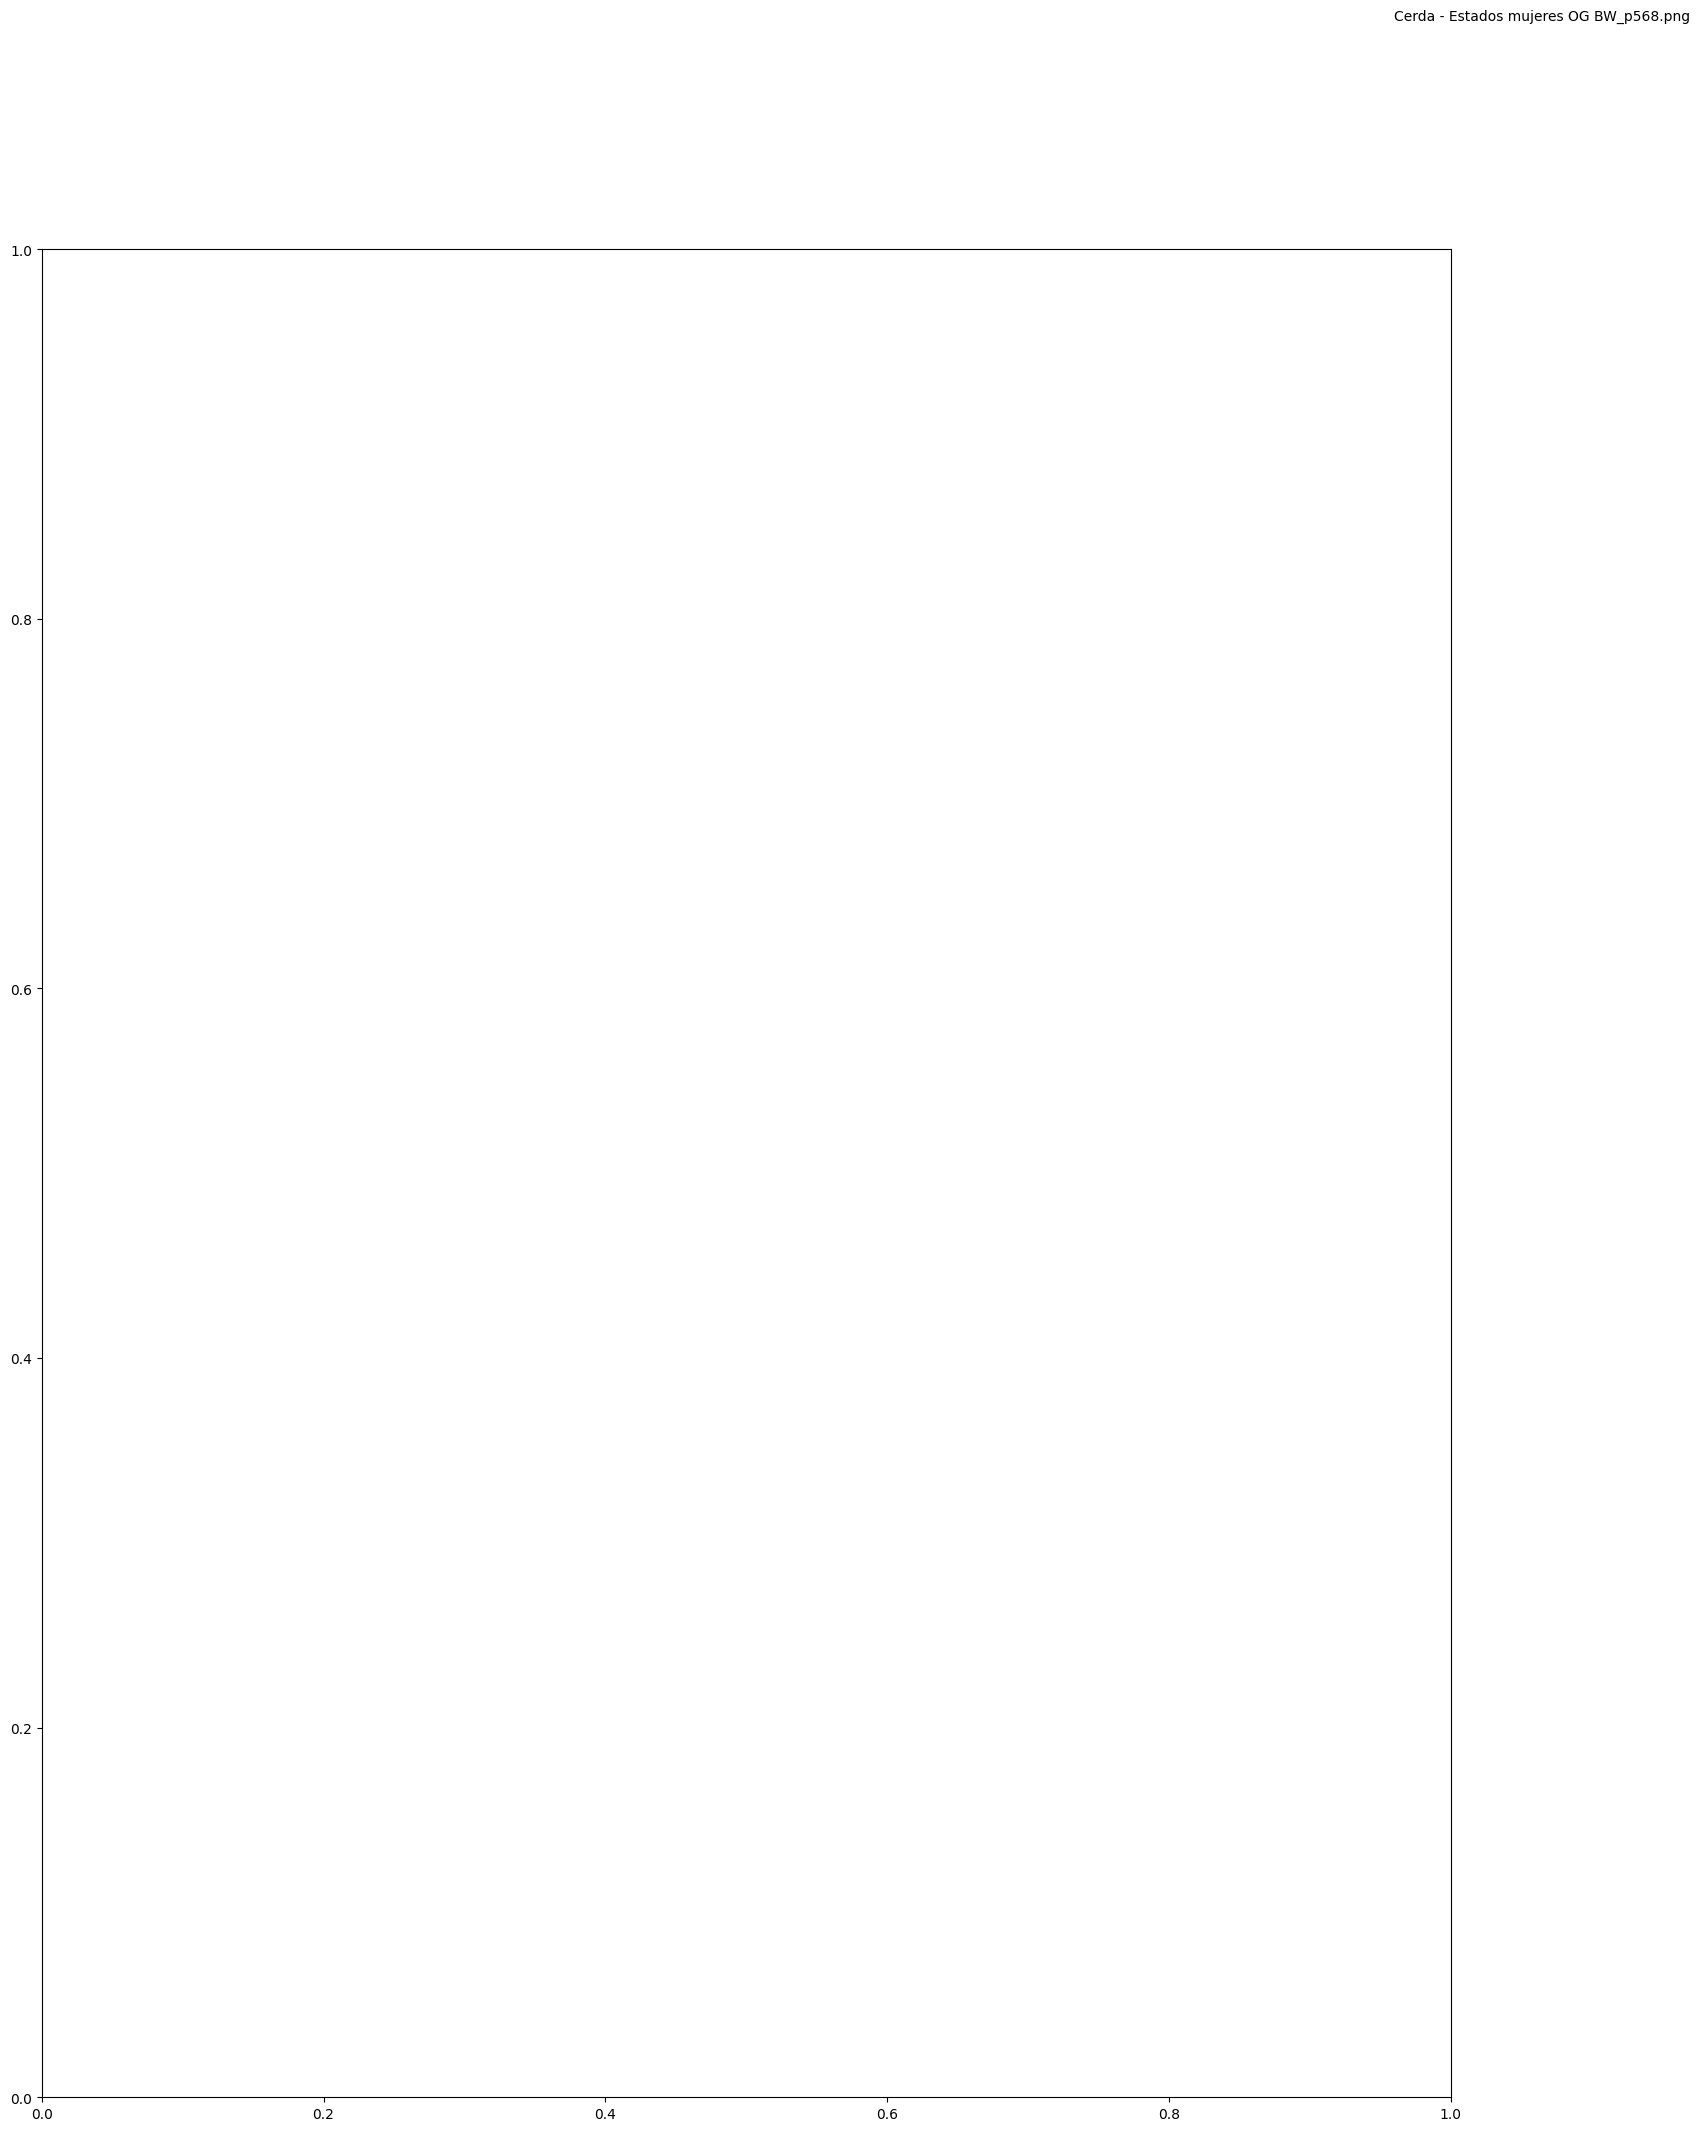

In [97]:
# Preview a Sample of Processed PNGs

import os
import random
import cv2
import matplotlib.pyplot as plt

# Directory containing your processed PNGs
processed_dir = r'c:\data\processed_data'

# Get all PNG filenames
png_files = [f for f in os.listdir(processed_dir) if f.lower().endswith('.png')]

# Sample up to 6 files (or fewer if less available)
sample_files = random.sample(png_files, min(6, len(png_files)))

for fname in sample_files:
    orig_path = os.path.join(png_dir, fname)
    proc_path = os.path.join(processed_dir, fname)

    orig = cv2.imread(orig_path, cv2.IMREAD_COLOR)
    proc = None
    if os.path.exists(proc_path):
        proc = cv2.imread(proc_path, cv2.IMREAD_GRAYSCALE)
# Plot side-by-side
    plt.figure(figsize=(40, 24))
    plt.suptitle(fname, fontsize=10)

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(proc, cmap='gray')
    plt.title("Processed")
    plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
import os
import cv2
from pathlib import Path

def resize_all_pngs(input_dir, output_dir, max_side=1280):
    """
    Resize all .png images in input_dir so that the longest side is max_side,
    and save them to output_dir with the same filename.
    
    Parameters:
        input_dir (str): Path to folder containing PNG images.
        output_dir (str): Path to folder where resized images will be saved.
        max_side (int): Max width or height in pixels. Default is 1280.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    png_files = list(input_dir.glob("*.png"))

    for image_path in png_files:
        img = cv2.imread(str(image_path))
        if img is None:
            print(f"⚠️ Could not read: {image_path}")
            continue

        h, w = img.shape[:2]
        scale = min(max_side / h, max_side / w)
        if scale >= 1.0:
            resized = img  # don't upscale
        else:
            new_w, new_h = int(w * scale), int(h * scale)
            resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

        output_path = output_dir / image_path.name
        cv2.imwrite(str(output_path), resized)
        print(f"✅ Resized: {image_path.name} → {output_path.name} ({resized.shape[1]}x{resized.shape[0]})")

    print(f"\n🎉 Finished resizing {len(png_files)} image(s). Resized images saved to: {output_dir}")

resize_all_pngs(processed_dir, processed_resized_dir, max_side=1280)


NameError: name 'processed_dir' is not defined

## CRAFT Bounding Box Detection

In [ ]:
!git clone https://github.com/clovaai/CRAFT-pytorch

Cloning into 'CRAFT-pytorch'...


#### CRAFT Pretrained Weights

In [ ]:
import os
import gdown

# Set the path to the weights folder inside CRAFT-pytorch
craft_dir = os.path.join("CRAFT-pytorch", "weights")
os.makedirs(craft_dir, exist_ok=True)

# Dictionary of pretrained model URLs (GDrive file IDs)
urls = {
    "craft_mlt_25k.pth": "1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ",
    "craft_ic15_20k.pth": "1i2R7UIUqmkUtF0jv_3MXTqmQ_9wuAnLf",
    "craft_refiner_CTW1500.pth": "1XSaFwBkOaFOdtk4Ane3DFyJGPRw6v5bO"
}

# Download each file
for name, file_id in urls.items():
    output_path = os.path.join(craft_dir, name)
    url = f"https://drive.google.com/uc?id={file_id}"
    print(f"Downloading {name} to {output_path}...")
    gdown.download(url, output_path, quiet=False)
    print(f"✔ Downloaded {name}")

print("All CRAFT weights saved successfully.")

Downloading...
From: https://drive.google.com/uc?id=1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ
To: c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance\RenAIssance_CRNN_OCR_Kate_OReilly\CRAFT-pytorch\weights\craft_mlt_25k.pth
100%|██████████| 83.2M/83.2M [00:02<00:00, 29.5MB/s]


✔ Downloaded craft_mlt_25k.pth


Downloading...
From: https://drive.google.com/uc?id=1i2R7UIUqmkUtF0jv_3MXTqmQ_9wuAnLf
To: c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance\RenAIssance_CRNN_OCR_Kate_OReilly\CRAFT-pytorch\weights\craft_ic15_20k.pth
100%|██████████| 83.2M/83.2M [00:02<00:00, 28.0MB/s]


✔ Downloaded craft_ic15_20k.pth


Downloading...
From: https://drive.google.com/uc?id=1XSaFwBkOaFOdtk4Ane3DFyJGPRw6v5bO
To: c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance\RenAIssance_CRNN_OCR_Kate_OReilly\CRAFT-pytorch\weights\craft_refiner_CTW1500.pth
100%|██████████| 1.85M/1.85M [00:00<00:00, 8.01MB/s]

✔ Downloaded craft_refiner_CTW1500.pth
All CRAFT weights saved successfully.


#### Import Modules

In [ ]:
import os
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
# from jiwer import wer, cer
import editdistance

import os
import sys

project_root = os.path.abspath("CRAFT-pytorch")
if project_root not in sys.path:
    sys.path.append(project_root)

print("Resolved project root:", project_root)
print("Files in that directory:", os.listdir(project_root))


from pathlib import Path
from torchvision import transforms
import importlib.util

craft_path = os.path.abspath("CRAFT-pytorch/craft.py")
spec = importlib.util.spec_from_file_location("craft", craft_path)
craft_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(craft_module)

CRAFT = craft_module.CRAFT

from craft_utils import getDetBoxes
from imgproc import normalizeMeanVariance
from PIL import Image

Resolved project root: c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance\RenAIssance_CRNN_OCR_Kate_OReilly\CRAFT-pytorch
Files in that directory: ['.git', '.gitignore', 'basenet', 'craft.py', 'craft_utils.py', 'figures', 'file_utils.py', 'imgproc.py', 'LICENSE', 'README.md', 'refinenet.py', 'requirements.txt', 'test.py', 'weights', '__pycache__']


c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance\venv\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


#### Configure CRAFT model


In [ ]:
INPUT_FOLDER = processed_dir
print("Files in that directory:", os.listdir(INPUT_FOLDER))

CRAFT_MODEL_PATH = 'CRAFT-pytorch/weights/craft_mlt_25k.pth'
OUTPUT_OVERLAY = 'output/craft/overlays'
OUTPUT_BOXES = 'output/craft/boxes'

os.makedirs(OUTPUT_OVERLAY, exist_ok=True)
os.makedirs(OUTPUT_BOXES, exist_ok=True)

Files in that directory: ['Ayala, Lorenzo de. Valladolid 1603_p007.png', 'Ayala, Lorenzo de. Valladolid 1603_p008.png', 'Ayala, Lorenzo de. Valladolid 1603_p018.png', 'Ayala, Lorenzo de. Valladolid 1603_p020.png', 'Ayala, Lorenzo de. Valladolid 1603_p024.png', 'Burgos, Juan de. Valladolid 1500_p007.png', 'Burgos, Juan de. Valladolid 1500_p010.png', 'Burgos, Juan de. Valladolid 1500_p017.png', 'Burgos, Juan de. Valladolid 1500_p021.png', 'Burgos, Juan de. Valladolid 1500_p024.png', 'Cansoles, Fernando. Mallorca 1541_p003.png', 'Cansoles, Fernando. Mallorca 1541_p009.png', 'Cansoles, Fernando. Mallorca 1541_p010.png', 'Cansoles, Fernando. Mallorca 1541_p012.png', 'Cansoles, Fernando. Mallorca 1541_p021.png', 'Cerda - Estados mujeres OG BW_p221.png', 'Cerda - Estados mujeres OG BW_p265.png', 'Cerda - Estados mujeres OG BW_p362.png', 'Cerda - Estados mujeres OG BW_p370.png', 'Cerda - Estados mujeres OG BW_p609.png', 'Guevara - Reloj de Principes OG_p060.png', 'Guevara - Reloj de Principes 

#### Utility Function

In [ ]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return np.array(image)

def save_overlay(image, boxes, save_path):
    for box in boxes:
        pts = np.array(box).reshape((-1, 1, 2)).astype(np.int32)
        cv2.polylines(image, [pts], True, (0, 255, 0), thickness=2)
    cv2.imwrite(save_path, image)

def save_boxes_txt(boxes, save_path):
    with open(save_path, 'w') as f:
        for box in boxes:
            flattened = [str(coord) for point in box for coord in point]
            f.write(','.join(flattened) + '\n')

#### Load CRAFT Model

In [ ]:
# Path to your model
CRAFT_MODEL_PATH = 'CRAFT-pytorch/weights/craft_mlt_25k.pth'

# Initialize the model
craft_net = CRAFT()

# Load weights and remove 'module.' prefixes
state_dict = torch.load(CRAFT_MODEL_PATH, map_location='cpu')
new_state_dict = {}

for k, v in state_dict.items():
    new_key = k.replace('module.', '')  # strip 'module.' if present
    new_state_dict[new_key] = v

# Load the cleaned state_dict
craft_net.load_state_dict(new_state_dict)

# Set model to evaluation mode
craft_net.eval()

print("CRAFT model loaded successfully.")

c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance\venv\lib\site-packages\torchvision\models\_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and may be removed in the future. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


CRAFT model loaded successfully.


#### Run Detection

#### Main Loop

In [ ]:
from pathlib import Path
import os

# Folders
ORIGINAL_DIR = Path("c:/data/processed")
RESIZED_DIR = Path("c:/data/processed_resized")
OUTPUT_BOXES = "output/craft/boxes"
OUTPUT_OVERLAY = "output/craft/overlays"

os.makedirs(OUTPUT_BOXES, exist_ok=True)
os.makedirs(OUTPUT_OVERLAY, exist_ok=True)

# Loop through original images
for original_img_path in ORIGINAL_DIR.glob("*.png"):
    filename = original_img_path.stem
    resized_img_path = RESIZED_DIR / (filename + ".png")

    # Check that resized image exists
    if not resized_img_path.exists():
        print(f"⚠️ Skipping {filename}: resized version not found.")
        continue

    # --- Step 1: Run CRAFT on original
    image_np = load_image(str(original_img_path))
    boxes = run_craft(image_np)  # assume this returns boxes in original scale

    # --- Step 2: Save .txt output
    txt_output_path = os.path.join(OUTPUT_BOXES, f"{filename}.txt")
    save_boxes_txt(boxes, txt_output_path)

    # --- Step 3: Draw on resized image
    resized_image_np = load_image(str(resized_img_path))
    
    # ⚠️ Scale boxes to match resized image
    h_orig, w_orig = image_np.shape[:2]
    h_resized, w_resized = resized_image_np.shape[:2]
    sx, sy = w_resized / w_orig, h_resized / h_orig

    boxes_rescaled = [[[x * sx, y * sy] for x, y in box] for box in boxes]

    overlay_output_path = os.path.join(OUTPUT_OVERLAY, f"{filename}_overlay.jpg")
    save_overlay(resized_image_np.copy(), boxes_rescaled, overlay_output_path)

    print(f"✅ Processed {filename}")


In [ ]:
image_paths = list(Path(INPUT_FOLDER).glob("*.png"))

for img_path in image_paths:
    filename = img_path.stem
    image_np = load_image(str(img_path))
    boxes = run_craft(image_np)

    overlay_path = os.path.join(OUTPUT_OVERLAY, f"{filename}_overlay.jpg")
    txt_path = os.path.join(OUTPUT_BOXES, f"{filename}.txt")

    save_overlay(image_np.copy(), boxes, overlay_path)
    save_boxes_txt(boxes, txt_path)

print(f"Processed all files")


Processed all files


#### Visual Representations of Bounding Boxes

In [ ]:
import os
import cv2

def draw_bounding_boxes(image_path, boxes_path, output_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Could not read {image_path}")
        return

    with open(boxes_path, 'r') as f:
        lines = f.read().split(';')  

    for group in lines:
        for line in group.strip().splitlines():
            try:
                coords = list(map(float, line.strip().split(',')))
                if len(coords) == 8:
                    pts = [(int(coords[i]), int(coords[i+1])) for i in range(0, 8, 2)]
                    for j in range(4):
                        cv2.line(image, pts[j], pts[(j+1)%4], (0, 255, 0), 2)
            except ValueError:
                print(f"Skipping malformed line: {line}")
                continue

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, image)

